### Reference

YOLO v5

<a href='https://pytorch.org/hub/ultralytics_yolov5/'>PyTorch docs</a>

<a href='https://github.com/ultralytics/yolov5'>GitHub</a>

<a href='https://github.com/ultralytics/yolov5/blob/master/models/yolov5s.yaml'>Config file example</a>

<a href='https://towardsdatascience.com/the-practical-guide-for-object-detection-with-yolov5-algorithm-74c04aac4843'>Practice Guide</a>

<a href='https://docs.ultralytics.com/yolov5/tutorials/transfer_learning_with_frozen_layers/'>Transfer Learning</a>

YOLO v8

<a href='https://docs.ultralytics.com/yolov5/tutorials/train_custom_data/#11-create-datasetyaml'>Quick Start</a>


<a href='https://docs.ultralytics.com/modes/train/'>Modes</a>

<a href='https://docs.ultralytics.com/usage/cfg/'>Configuration</a>

<a href='https://docs.ultralytics.com/datasets/detect/'>Yolo Dataset Format</a>

<a href='https://www.freecodecamp.org/news/how-to-detect-objects-in-images-using-yolov8/'>Practice Guide</a>

<a href='https://github.com/ultralytics/ultralytics/blob/main/docs/models/yolov8.md'>GitHub</a>


In [1]:
!pip install -q split-folders

In [2]:
import os
import time
from tqdm.notebook import tqdm

# download data
import cv2
from PIL import Image
from pathlib import Path
import splitfolders

# from efficientnet_pytorch import EfficientNet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, models, transforms, datapoints
from torchvision.datasets import ImageFolder
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.v2 import functional as FT

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [3]:
# Проверим доступность GPU на CUDA
torch.cuda.is_available()
use_gpu = torch.cuda.is_available()
use_gpu

True

In [4]:
# Добавим cuda на девайс
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [5]:
# celeba images 0-30k archive
!gdown 1MIA99QUIxXvaBFOZFbVsVoYJPL-6_FzN -O /content/celeba/

# identity person
!gdown 1ZEKVXe54rFwI2vPgCKDGE-d0BJWZ2NDp -O /content/celeba/

# image attributes
!gdown 1Upj8NyGp7nGoslEuQHirfjYFHA37PJCa -O /content/celeba/

# image bbox
!gdown 1Tvpz-ZHeYpwhe16_QJwUCjY416d9z-ar -O /content/celeba/

Downloading...
From: https://drive.google.com/uc?id=1MIA99QUIxXvaBFOZFbVsVoYJPL-6_FzN
To: /content/celeba/0-30k.zip
100% 1.56G/1.56G [00:14<00:00, 110MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZEKVXe54rFwI2vPgCKDGE-d0BJWZ2NDp
To: /content/celeba/identity_CelebA.txt
100% 3.42M/3.42M [00:00<00:00, 205MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Upj8NyGp7nGoslEuQHirfjYFHA37PJCa
To: /content/celeba/list_attr_celeba.txt
100% 26.7M/26.7M [00:00<00:00, 180MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Tvpz-ZHeYpwhe16_QJwUCjY416d9z-ar
To: /content/celeba/list_bbox_celeba.txt
100% 6.08M/6.08M [00:00<00:00, 114MB/s]


In [6]:
mkdir -p /content/celeba/images/

In [7]:
!unzip /content/celeba/0-30k.zip  -d /content/celeba/images/ &>/dev/null

In [8]:
ROOT = "/content/celeba/images/"
ALL_IMAGES = list(Path(ROOT).glob("**/*.jpg"))
ALL_IMAGES = list(filter(lambda x: not x.name.startswith("."), ALL_IMAGES))
print("Number of images:", len(ALL_IMAGES))

INPUT_PATH = '/content/celeba/'
SPLIT_PATH = '/content/celeba/split'
TEST_PATH = SPLIT_PATH / Path("test")
TRAIN_PATH = SPLIT_PATH / Path("train")
VAL_PATH = SPLIT_PATH / Path("val")

splitfolders.ratio(
                    INPUT_PATH,
                    SPLIT_PATH,
                    seed=42,
                    ratio=(.8, .1, .1),
                    group_prefix=None,
                    move=False
)


Number of images: 30000


Copying files: 30000 files [00:07, 4089.81 files/s]


In [9]:
def inv_transforms(img):
  inv_transforms = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])
  return inv_transforms(img)

In [10]:
def get_label_names(labels, label_names):
  labels = labels.cpu().tolist()
  return [label_names[x] for x in labels]

In [11]:
def show_preds(image, prediction=None, threshold=None):
  if prediction is not None and threshold is not None:
    img = inv_transforms(image)
    img = FT.convert_dtype(img, torch.uint8)
    boxes = prediction['boxes'][prediction['scores'] > CONF_THRESH]
    label = prediction['labels'][prediction['scores'] > CONF_THRESH]
  elif prediction is not None and threshold is None:
    img = inv_transforms(image)
    img = FT.convert_dtype(img, torch.uint8)
    boxes = prediction
    label = torch.tensor([1])
  else:
    img = inv_transforms(image[0])
    img = FT.convert_dtype(img, torch.uint8)
    boxes = image[1]['boxes']
    label = image[1]['labels']
  label = get_label_names(label, label_names)
  annotated_image = draw_bounding_boxes(img, boxes, labels=label, colors="red", width=1)
  fig, ax = plt.subplots()
  ax.imshow(annotated_image.permute(1, 2, 0).cpu().numpy())
  ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
  fig.tight_layout()
  fig.show()

In [12]:
bbox_celeba = pd.read_csv('/content/celeba/list_bbox_celeba.txt', delim_whitespace=True, header=1)
bbox_celeba.head()
# x_1 and y_1 represent the upper left point coordinate of bounding box.
bbox_celeba.head()

,image_id,x_1,y_1,width,height
0,000001.jpg,95,71,226,313
1,000002.jpg,72,94,221,306
2,000003.jpg,216,59,91,126
3,000004.jpg,622,257,564,781
4,000005.jpg,236,109,120,166


In [13]:
bbox_celeba['x_center'] = bbox_celeba['x_1'] + bbox_celeba['width'] / 2
bbox_celeba['y_center'] = bbox_celeba['y_1'] + bbox_celeba['height'] / 2
bbox_celeba.head()

,image_id,x_1,y_1,width,height,x_center,y_center
0,000001.jpg,95,71,226,313,208.0,227.5
1,000002.jpg,72,94,221,306,182.5,247.0
2,000003.jpg,216,59,91,126,261.5,122.0
3,000004.jpg,622,257,564,781,904.0,647.5
4,000005.jpg,236,109,120,166,296.0,192.0


In [14]:
bbox_celeba = bbox_celeba[['image_id', 'x_center', 'y_center', 'width', 'height']]
bbox_celeba.head()

,image_id,x_center,y_center,width,height
0,000001.jpg,208.0,227.5,226,313
1,000002.jpg,182.5,247.0,221,306
2,000003.jpg,261.5,122.0,91,126
3,000004.jpg,904.0,647.5,564,781
4,000005.jpg,296.0,192.0,120,166


In [15]:
bbox_celeba['img_width'] = 0
bbox_celeba['img_height'] = 0

ALL_IMAGES = sorted(ALL_IMAGES)
for i, path in enumerate(ALL_IMAGES):
  img = Image.open(path).convert("RGB")
  bbox_celeba['img_width'][i] = img.size[0]
  bbox_celeba['img_height'][i] = img.size[1]

<ipython-input-15-eaf9db22e278>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbox_celeba['img_width'][i] = img.size[0]
<ipython-input-15-eaf9db22e278>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbox_celeba['img_height'][i] = img.size[1]


In [16]:
bbox_celeba.head()

,image_id,x_center,y_center,width,height,img_width,img_height
0,000001.jpg,208.0,227.5,226,313,409,687
1,000002.jpg,182.5,247.0,221,306,423,594
2,000003.jpg,261.5,122.0,91,126,500,281
3,000004.jpg,904.0,647.5,564,781,1648,2464
4,000005.jpg,296.0,192.0,120,166,610,826


In [17]:
bbox_celeba['x_center_norm'] = bbox_celeba['x_center'] / bbox_celeba['img_width']
bbox_celeba['y_center_norm'] = bbox_celeba['y_center'] / bbox_celeba['img_height']
bbox_celeba['width_norm'] = bbox_celeba['width'] / bbox_celeba['img_width']
bbox_celeba['height_norm'] = bbox_celeba['height'] / bbox_celeba['img_height']
bbox_celeba.head()

,image_id,x_center,y_center,width,height,img_width,img_height,x_center_norm,y_center_norm,width_norm,height_norm
0,000001.jpg,208.0,227.5,226,313,409,687,0.508557,0.331150,0.552567,0.455604
1,000002.jpg,182.5,247.0,221,306,423,594,0.431442,0.415825,0.522459,0.515152
2,000003.jpg,261.5,122.0,91,126,500,281,0.523000,0.434164,0.182000,0.448399
3,000004.jpg,904.0,647.5,564,781,1648,2464,0.548544,0.262784,0.342233,0.316964
4,000005.jpg,296.0,192.0,120,166,610,826,0.485246,0.232446,0.196721,0.200969


In [18]:
bbox_celeba = bbox_celeba[['image_id', 'x_center_norm', 'y_center_norm', 'width_norm', 'height_norm']]
bbox_celeba.head()

,image_id,x_center_norm,y_center_norm,width_norm,height_norm
0,000001.jpg,0.508557,0.331150,0.552567,0.455604
1,000002.jpg,0.431442,0.415825,0.522459,0.515152
2,000003.jpg,0.523000,0.434164,0.182000,0.448399
3,000004.jpg,0.548544,0.262784,0.342233,0.316964
4,000005.jpg,0.485246,0.232446,0.196721,0.200969


In [19]:
all_bboxes = bbox_celeba.to_numpy()
all_bboxes[:3]

array([['000001.jpg', 0.508557457212714, 0.3311499272197962,
        0.5525672371638142, 0.4556040756914119],
       ['000002.jpg', 0.4314420803782506, 0.4158249158249158,
        0.5224586288416075, 0.5151515151515151],
       ['000003.jpg', 0.523, 0.43416370106761565, 0.182,
        0.4483985765124555]], dtype=object)

In [20]:
all_bboxes = np.insert(all_bboxes, 1, 0, axis = 1)
all_bboxes[:3]

array([['000001.jpg', 0, 0.508557457212714, 0.3311499272197962,
        0.5525672371638142, 0.4556040756914119],
       ['000002.jpg', 0, 0.4314420803782506, 0.4158249158249158,
        0.5224586288416075, 0.5151515151515151],
       ['000003.jpg', 0, 0.523, 0.43416370106761565, 0.182,
        0.4483985765124555]], dtype=object)

In [21]:
image_names = sorted(os.listdir(TRAIN_PATH / Path("images")))
image_names[:3]

['000001.jpg', '000002.jpg', '000003.jpg']

In [22]:
len(image_names)

24000

In [23]:
val_image_names = sorted(os.listdir(VAL_PATH / Path("images")))
val_image_names[:3]

['000006.jpg', '000023.jpg', '000036.jpg']

In [24]:
train_bboxes = []
for i in image_names:
  train_bboxes.append(all_bboxes[:, 1:][np.where(all_bboxes[:, 0] == i)].reshape(-1).tolist())
train_bboxes[:3]

[[0,
  0.508557457212714,
  0.3311499272197962,
  0.5525672371638142,
  0.4556040756914119],
 [0,
  0.4314420803782506,
  0.4158249158249158,
  0.5224586288416075,
  0.5151515151515151],
 [0, 0.523, 0.43416370106761565, 0.182, 0.4483985765124555]]

In [25]:
len(train_bboxes)

24000

In [26]:
mkdir -p /content/celeba/split/train/labels/

In [27]:
for name, array in zip(image_names, train_bboxes):
  pd.DataFrame(array).transpose().to_csv(f'/content/celeba/split/train/labels/{name[:6]}.txt', header=False, sep=' ', index=False)

In [28]:
val_bboxes = []
for i in val_image_names:
  val_bboxes.append(all_bboxes[:, 1:][np.where(all_bboxes[:, 0] == i)].reshape(-1).tolist())
val_bboxes[:3]

[[0,
  0.5780487804878048,
  0.32491582491582494,
  0.44390243902439025,
  0.42424242424242425],
 [0,
  0.6520190023752969,
  0.4276094276094276,
  0.5486935866983373,
  0.5387205387205387],
 [0,
  0.41228070175438597,
  0.22983870967741934,
  0.3132832080200501,
  0.27903225806451615]]

In [29]:
len(val_bboxes)

3000

In [30]:
pd.DataFrame(array).transpose()

,0,1,2,3,4
0,0.0,0.6625,0.328571,0.360714,0.5


In [31]:
mkdir -p /content/celeba/split/val/labels/

In [32]:
for name, array in zip(val_image_names, val_bboxes):
  pd.DataFrame(array).transpose().to_csv(f'/content/celeba/split/val/labels/{name[:6]}.txt', header=False, sep=' ', index=False)

In [33]:
%%bash
pip install -U ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.6/612.6 kB 34.6 MB/s eta 0:00:00


In [34]:
# yolo v5
# model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

In [35]:
from ultralytics import YOLO

In [36]:
model = YOLO('yolov8s.pt')

100%|██████████| 21.5M/21.5M [00:00<00:00, 330MB/s]


In [37]:
model

### TRAIN

In [38]:
# all params: https://docs.ultralytics.com/modes/train/#arguments
model.train(
   data='/content/drive/MyDrive/Colab Notebooks/dataset.yaml',
   epochs=3,
   batch=8,
   name='yolov8s_custom',
   save=True,
   save_period=1,
   device=DEVICE)

Ultralytics YOLOv8.0.124 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/Colab Notebooks/dataset.yaml, epochs=3, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=yolov8s_custom, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, op

### PREDICT

In [ ]:
result = model.predict('/content/celeba/split/test/images/')

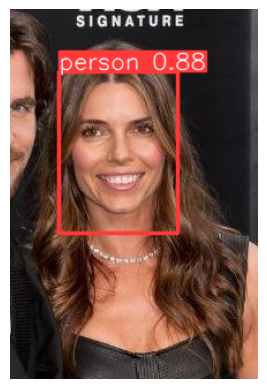

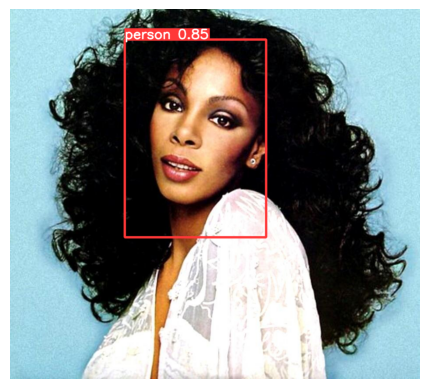

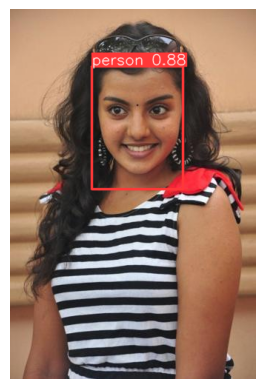

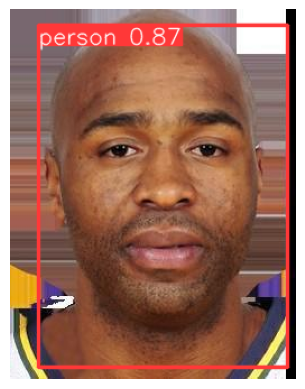

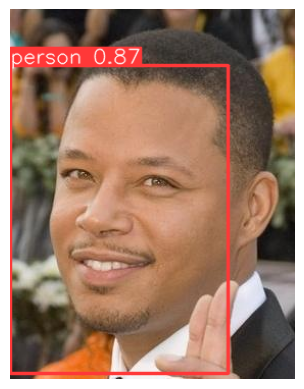

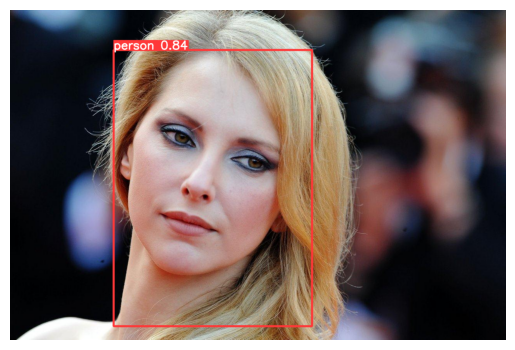

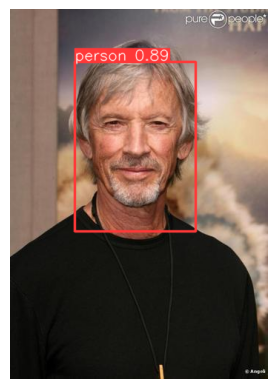

In [47]:
for res in result[9:16]:
  res_plotted = res.plot()
  plt.imshow(res_plotted[...,::-1])
  plt.axis("off")
  plt.show()

### RESUME TRAINING

In [ ]:
# Load a model
# model = YOLO('/content/runs/detect/yolov8s_custom/weights/best.pt')  # load a partially trained model

# Resume training
# model.train(resume=True)